In [1]:
import sys
sys.path.append("../code/")
import util_ElasticNet, lib_LinearAlgebra, util_hdf5, lib_Checker, lib_ElasticNet
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py, yaml
import matplotlib.pyplot as plt
from importlib import reload  
lib_LinearAlgebra = reload(lib_LinearAlgebra)
util_ElasticNet = reload(util_ElasticNet)
util_hdf5 = reload(util_hdf5)
lib_Checker = reload(lib_Checker)
import util_hdf5
import logging, sys
import seaborn as sns
import functools
logging.basicConfig(
    level = logging.INFO, 
    stream = sys.stderr, 
    format = '%(asctime)s  %(message)s',
    datefmt = '%Y-%m-%d %I:%M:%S %p'
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[2], 'GPU')

# Test on Chinese

Some basic input setups.

In [2]:
hdf5_test = '/vol/bmd/yanyul/UKB/predicted_expression_tf2/ukb_imp_x_ctimp_Whole_Blood_Chinese.hdf5'
scheme_yaml = '../misc_files/data_scheme.yaml'
feature_dic = util_hdf5.read_yaml(scheme_yaml)
with h5py.File(hdf5_test, 'r') as f:
    features = f['columns_y'][:].astype('str')
    y = f['y'][:]
covar_indice = np.where(np.isin(features, feature_dic['covar_names']))[0]
trait_indice = np.where(np.isin(features, feature_dic['outcome_names']))[0]
# load data_scheme for training
batch_size = 280
print(f'batch_size in the British set (for code testing) is {batch_size}')
data_scheme, sample_size = util_hdf5.build_data_scheme(
    hdf5_test, 
    scheme_yaml, 
    batch_size = batch_size, 
    inv_norm_y = True
)

# set validation and test set as the first and second batch
dataset_valid = data_scheme.dataset.take(1)
data_scheme.dataset = data_scheme.dataset.skip(1)
dataset_test = data_scheme.dataset.take(1)
data_scheme.dataset = data_scheme.dataset.skip(1)
dataset_insample = data_scheme.dataset.take(1)


ntrain = sample_size - 2 * batch_size
train_batch = batch_size

batch_size in the British set (for code testing) is 280


In [3]:
for x, y in data_scheme.dataset:
    print(x.shape)
    print(y.shape)
    print(sample_size)

(280, 7044)
(280, 42)
1326
(280, 7044)
(280, 42)
1326
(206, 7044)
(206, 42)
1326


Run elastic net solver

In [4]:
alpha = 0.1
learning_rate = 1
lambda_init_dict = {
    'data_init': None, 
    'prefactor_of_lambda_max': 1,
    'lambda_max_over_lambda_min': 1e3,
    'nlambda': 5
}
updater = lib_ElasticNet.ProximalUpdater(learning_rate = learning_rate, line_search = True)
update_dic = {
    'updater': updater,
    'update_fun': updater.proximal_train_step
}
my_stop_rule = functools.partial(lib_Checker.diff_stop_rule, threshold = 1e-2)
# updater = lib_ElasticNet.ProximalUpdater(learning_rate)
# data_scheme.dataset = data_scheme.dataset
# data_scheme.outcome_indice = [ 22, 23 ]
ny = len(data_scheme.outcome_indice)
elastic_net_estimator = lib_LinearAlgebra.ElasticNetEstimator(
    data_scheme,
    alpha,
    normalizer = True,
    learning_rate = learning_rate,
    lambda_init_dict = lambda_init_dict,
    updater = update_dic
)
checker = [ lib_Checker.Checker(ntrain, train_batch, lib_Checker.my_stat_fun, my_stop_rule) 
           for i in range(ny) ]

elastic_net_estimator.solve(checker, nepoch = 50, logging = logging)


2020-01-30 10:21:41 PM  start norm
2020-01-30 10:21:41 PM  end norm
2020-01-30 10:21:43 PM  Gone through outer loop 1 / 5 and inner loop 1 epoch
2020-01-30 10:21:44 PM  Gone through outer loop 1 / 5 and inner loop 2 epoch
2020-01-30 10:21:45 PM  Gone through outer loop 1 / 5 and inner loop 3 epoch
2020-01-30 10:21:46 PM  Gone through outer loop 1 / 5 and inner loop 4 epoch
2020-01-30 10:21:46 PM  Gone through outer loop 1 / 5 and inner loop 5 epoch
2020-01-30 10:21:48 PM  Gone through outer loop 2 / 5 and inner loop 1 epoch
2020-01-30 10:21:49 PM  Gone through outer loop 2 / 5 and inner loop 2 epoch
2020-01-30 10:21:50 PM  Gone through outer loop 3 / 5 and inner loop 1 epoch
2020-01-30 10:21:52 PM  Gone through outer loop 3 / 5 and inner loop 2 epoch
2020-01-30 10:21:52 PM  Gone through outer loop 3 / 5 and inner loop 3 epoch
2020-01-30 10:21:54 PM  Gone through outer loop 4 / 5 and inner loop 1 epoch
2020-01-30 10:21:55 PM  Gone through outer loop 4 / 5 and inner loop 2 epoch
2020-01-

{'obj': [array([0.40317774, 0.34229016, 0.32717333, 0.32401723, 0.32487569,
         0.3277626 , 0.24612667, 0.24295378, 0.24190597, 0.09068165,
         0.08750403, 0.08719959, 0.02050908, 0.02013786, 0.02022519]),
  array([0.43026471, 0.3596551 , 0.34120762, 0.33640373, 0.33516073,
         0.33499062, 0.33488985, 0.27729054, 0.2757531 , 0.10644695,
         0.10520967, 0.10691999, 0.02435464, 0.02449488]),
  array([0.42602197, 0.36057035, 0.34447026, 0.34079119, 0.34010398,
         0.3399208 , 0.33983823, 0.27199515, 0.26718024, 0.26471559,
         0.09978857, 0.09952115, 0.0237966 , 0.02367033]),
  array([0.39952687, 0.32653761, 0.3065811 , 0.30092833, 0.29923083,
         0.29849494, 0.29902027, 0.25026073, 0.24868675, 0.10524594,
         0.10342036, 0.10444292, 0.02493786, 0.02444819, 0.024592  ]),
  array([0.39527273, 0.32975227, 0.31239531, 0.30775257, 0.306488  ,
         0.306189  , 0.30606496, 0.24876459, 0.24651396, 0.09759821,
         0.09765227, 0.0234735 , 0.02339446

Save and load

In [5]:
elastic_net_estimator.minimal_save('test_en_chinese.hdf5')
loaded_en = lib_LinearAlgebra.ElasticNetEstimator('', None, minimal_load = True)
loaded_en.minimal_load('test_en_chinese.hdf5')

Saving lambda_seq
Saving beta_hat_path
Saving covar_hat_path
Saving intercept_path
Saving normalizer
Saving alpha
Saving data_scheme.dataset
Saving data_scheme.X_index
Saving data_scheme.Y_index
Saving data_scheme.outcome_indice
Saving data_scheme.covariate_indice
Saving data_scheme.num_predictors


(280, 17, 5)


/vol/bmd/yanyul/miniconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/vol/bmd/yanyul/miniconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


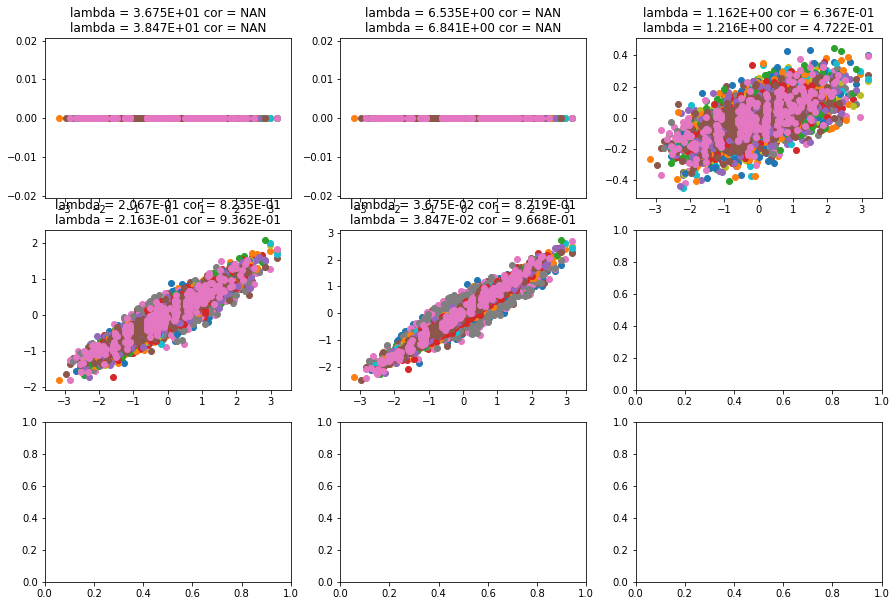

In [6]:
o1 = loaded_en.predict_x(
    dataset_insample, 
    loaded_en.beta_hat_path, 
)


out = o1
fig, aes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 10))
seq = [0, 1, 2, 3, 4, 5, 8, 10, 12, 16, 19]
for i in range(2):
    for j in range(3):
        idx = seq[(i * 3 + j)]
        if idx < len(loaded_en.lambda_seq[0]):
            for k in range(17):
                aes[i][j].scatter(out['y'][:,k], out['y_pred_from_x'][:, k, idx])
            aes[i][j].set_title(
                'lambda = ' + "{:.3E} cor = {:.3E}".format(
                    loaded_en.lambda_seq[0][idx], 
                    np.corrcoef(o1['y'][:, 0], o1['y_pred_from_x'][:, 0, idx])[0,1]
                ) + '\n' +
                'lambda = ' + "{:.3E} cor = {:.3E}".format(
                    loaded_en.lambda_seq[1][idx], 
                    np.corrcoef(o1['y'][:, 1], o1['y_pred_from_x'][:, 1, idx])[0,1]
                )
            )


(280, 17, 5)


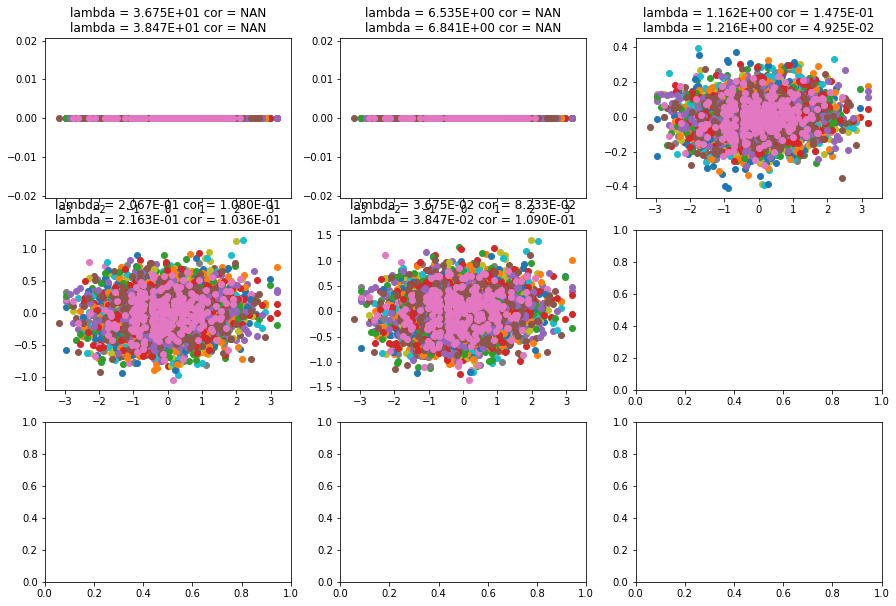

In [7]:
o1 = loaded_en.predict_x(
    dataset_valid, 
    loaded_en.beta_hat_path, 
)


out = o1
fig, aes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 10))
seq = [0, 1, 2, 3, 4, 5, 8, 10, 12, 16, 19]
for i in range(2):
    for j in range(3):
        idx = seq[(i * 3 + j)]
        if idx < len(loaded_en.lambda_seq[0]):
            for k in range(17):
                aes[i][j].scatter(out['y'][:,k], out['y_pred_from_x'][:, k, idx])
            aes[i][j].set_title(
                'lambda = ' + "{:.3E} cor = {:.3E}".format(
                    loaded_en.lambda_seq[0][idx], 
                    np.corrcoef(o1['y'][:, 0], o1['y_pred_from_x'][:, 0, idx])[0,1]
                ) + '\n' +
                'lambda = ' + "{:.3E} cor = {:.3E}".format(
                    loaded_en.lambda_seq[1][idx], 
                    np.corrcoef(o1['y'][:, 1], o1['y_pred_from_x'][:, 1, idx])[0,1]
                )
            )


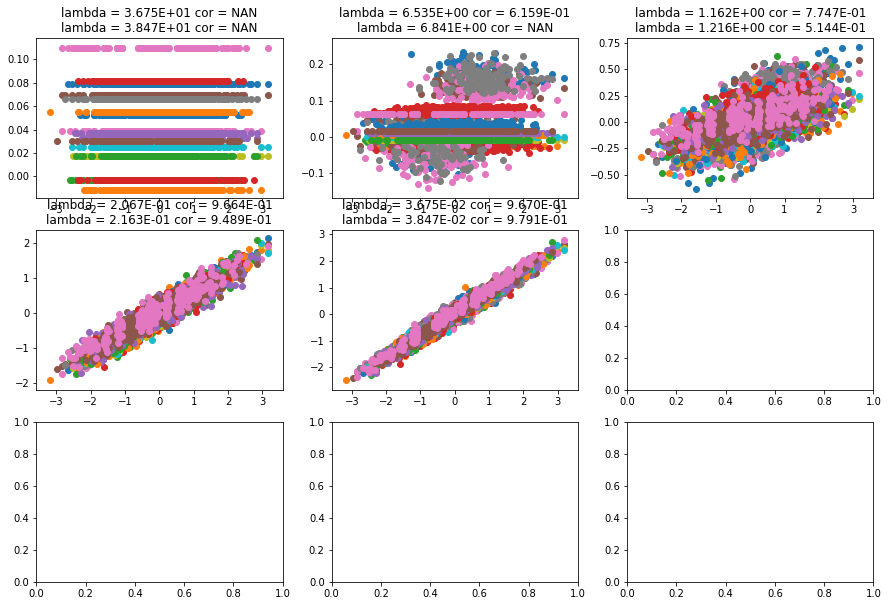

In [8]:
o1 = loaded_en.predict(
    dataset_insample, 
    loaded_en.beta_hat_path, 
    loaded_en.covar_hat_path,
    loaded_en.intercept_path
)
# o2 = least_square_solver.predict_x(dataset_insample)

out = o1
fig, aes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 10))
seq = [0, 1, 2, 3, 4, 5, 8, 10, 12, 16, 19]
for i in range(2):
    for j in range(3):
        idx = seq[(i * 3 + j)]
        if idx < len(loaded_en.lambda_seq[0]):
            for k in range(17):
                aes[i][j].scatter(out['y'][:,k], out['y_pred'][:, k, idx])
            aes[i][j].set_title(
                'lambda = ' + "{:.3E} cor = {:.3E}".format(
                    loaded_en.lambda_seq[0][idx], 
                    np.corrcoef(o1['y'][:, 0], o1['y_pred'][:, 0, idx])[0,1]
                ) + '\n' +
                'lambda = ' + "{:.3E} cor = {:.3E}".format(
                    loaded_en.lambda_seq[1][idx], 
                    np.corrcoef(o1['y'][:, 1], o1['y_pred'][:, 1, idx])[0,1]
                )
            )
